Energy Consumption Prediction for Energy4Climate
=======================

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')



In [2]:
tf.__version__

'1.15.0'

## 1. Data Processing

#### 1.1 Data Loading
We will load the data that is in .csv format. We choose the columns that interest us and organize the data by date. We also fill in missing data with the previous value so as not to cause any errors in the creation of the model

In [3]:
df = pd.read_csv('../Data/DrahiX_Data.csv', index_col=0, usecols=[0,1,2,3,12,13,14,19,20,21,22,23,24,25], parse_dates=True, nrows = 135000)
#df = pd.read_csv('New_Data.csv',index_col=0, parse_dates=True) usecols=[0,1,14,21,24]
df = df.fillna(0)
print(df.keys())

Index(['Global_Solar_Flux', 'Direct_Solar_Flux', 'Diffuse_Solar_Flux', 'SZA',
       'SAA', 'Pmax', 'Tp', 'POA', 'AirTemp', 'wd', 'ws', 'rh', 'rain'],
      dtype='object')


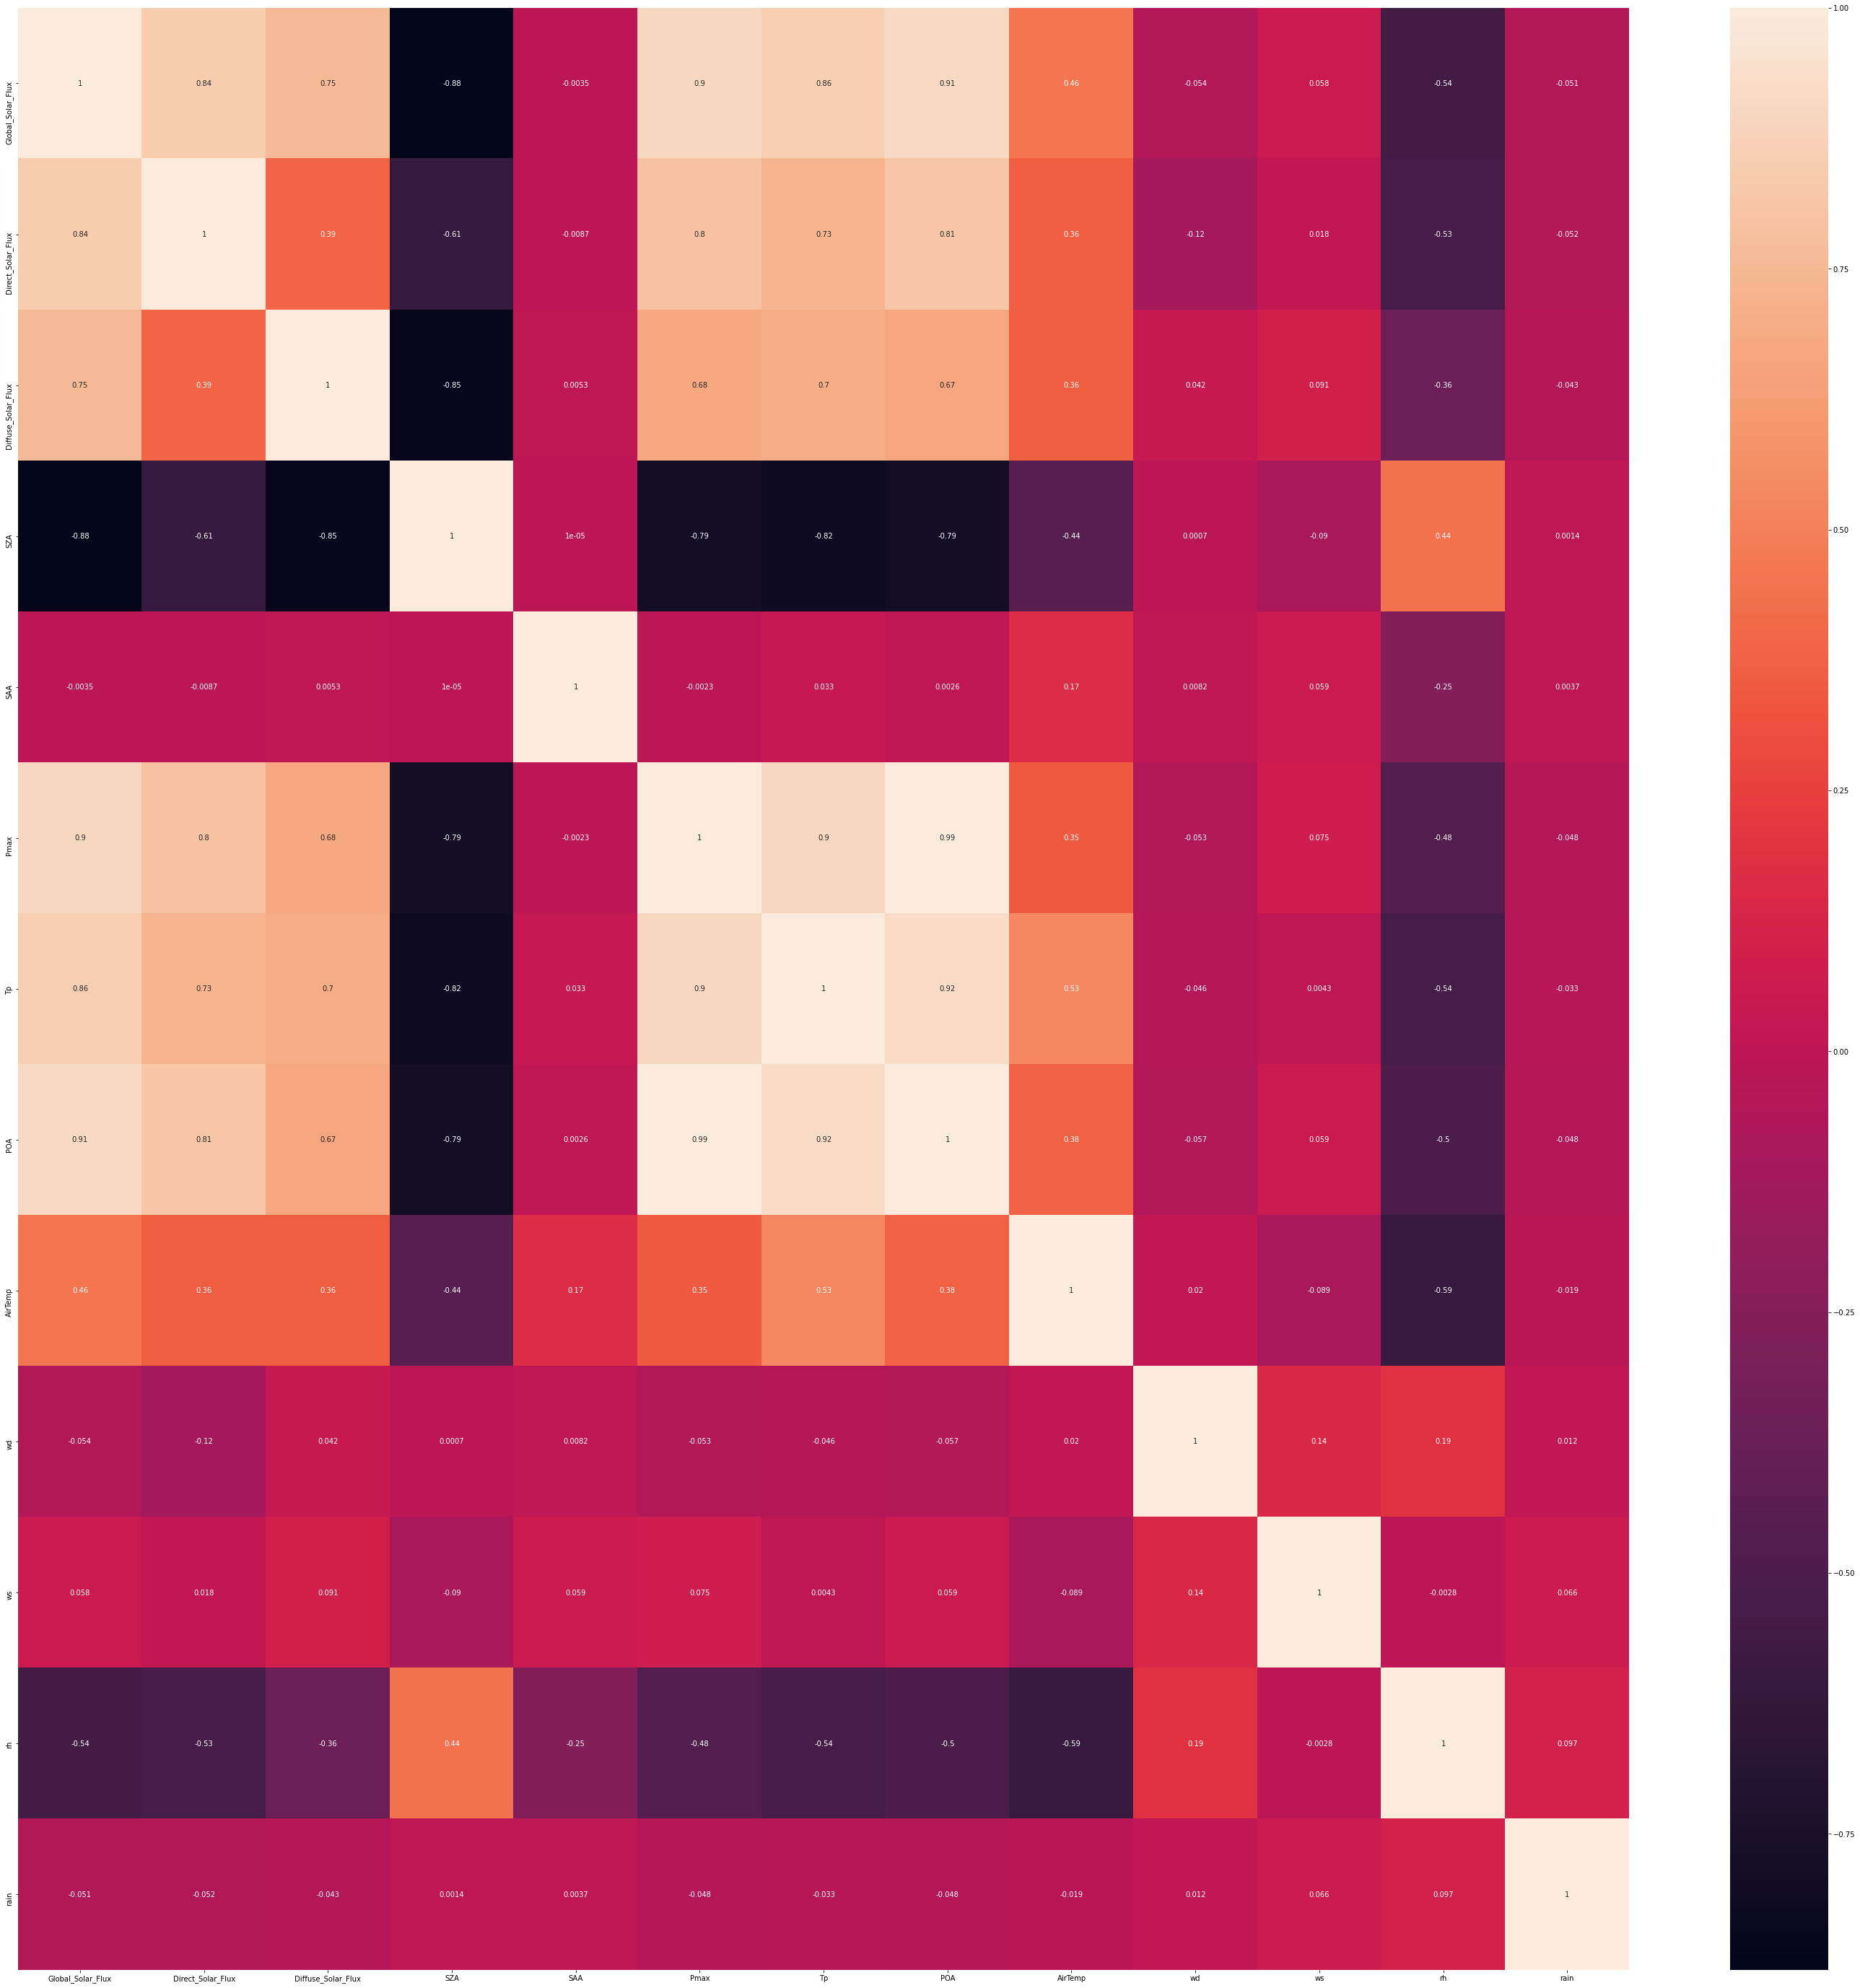

In [4]:
plt.figure(figsize=(50,50))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

In [5]:
corr = df.corr().iloc[5] #Take correlations values for Pmax
c = corr.abs()
so = c.sort_values(ascending=False)

print(so)

Pmax                  1.000000
POA                   0.993478
Tp                    0.903820
Global_Solar_Flux     0.901568
Direct_Solar_Flux     0.797887
SZA                   0.788926
Diffuse_Solar_Flux    0.679487
rh                    0.483754
AirTemp               0.347324
ws                    0.074870
wd                    0.053042
rain                  0.048022
SAA                   0.002339
Name: Pmax, dtype: float64


In [6]:
sequence_length = int(60/15*3)

#### 1.2 Data Resampling

We will reorganize the loaded data in 15 minute intervals and add new features related to date and time. 

In [7]:
df = df.resample('15Min').mean()
df = df.fillna(0)

df.index = df.index + pd.Timedelta(minutes=15*sequence_length)

#Adding new features so that we can use the date and time in the model
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['minute of the hour'] = df.index.minute

df = df.iloc[:-sequence_length]

In [8]:
df.head()

,Global_Solar_Flux,Direct_Solar_Flux,Diffuse_Solar_Flux,SZA,SAA,Pmax,Tp,POA,AirTemp,wd,ws,rh,rain,day of the week,day of the year,hour of the day,minute of the hour
Date and time (UTC),,,,,,,,,,,,,,,,,
2016-07-15 03:00:00+00:00,-1.16,-0.55,-1.38,90.0,-177.44,0.0,0.0,0.0,12.56,318.76,1.97,80.33,0.0,4,197,3,0
2016-07-15 03:15:00+00:00,-1.05,-0.53,-1.38,90.0,-173.74,0.0,0.0,0.0,12.46,304.54,1.78,80.67,0.0,4,197,3,15
2016-07-15 03:30:00+00:00,-1.00,-0.54,-1.38,90.0,-170.06,0.0,0.0,0.0,12.28,295.52,1.80,81.54,0.0,4,197,3,30
2016-07-15 03:45:00+00:00,-0.89,-0.51,-1.37,90.0,-166.41,0.0,0.0,0.0,12.32,300.86,2.65,82.41,0.0,4,197,3,45
2016-07-15 04:00:00+00:00,-0.98,-0.40,-1.37,90.0,-162.79,0.0,0.0,0.0,12.38,300.65,2.70,82.24,0.0,4,197,4,0


#### 1.3 Selection of Features and Targets 

After loading and reorganizing the data we can select the features that are useful for creating the model and the variables that will be predicted 

In [9]:
features = ['day of the year','hour of the day','rh', 'POA', 'Tp']
labels   = ["Pmax"]
inputs   = features + labels
df = df[inputs]

num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

df.head()

,day of the year,hour of the day,rh,POA,Tp,Pmax
Date and time (UTC),,,,,,
2016-07-15 03:00:00+00:00,197,3,80.33,0.0,0.0,0.0
2016-07-15 03:15:00+00:00,197,3,80.67,0.0,0.0,0.0
2016-07-15 03:30:00+00:00,197,3,81.54,0.0,0.0,0.0
2016-07-15 03:45:00+00:00,197,3,82.41,0.0,0.0,0.0
2016-07-15 04:00:00+00:00,197,4,82.24,0.0,0.0,0.0


#### 1.4 Data normalization 

Now we are going to normalize the data we have in the range between -1 and 1. These data are normalized independently between them and this facilitates the prediction by the model. 

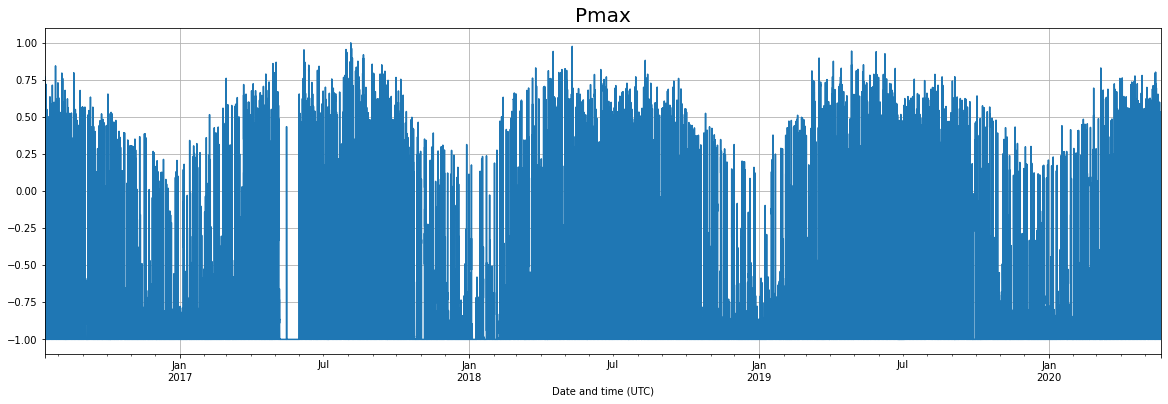

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    df_scaled[labels[i]].plot(ax=ax)
    plt.title(labels[i], fontsize=20)
    plt.grid(True)
    plt.show()

In [11]:
df_scaled

,day of the year,hour of the day,rh,POA,Tp,Pmax
Date and time (UTC),,,,,,
2016-07-15 03:00:00+00:00,0.073973,-0.739130,0.6066,-1.0,-0.196445,-1.0
2016-07-15 03:15:00+00:00,0.073973,-0.739130,0.6134,-1.0,-0.196445,-1.0
2016-07-15 03:30:00+00:00,0.073973,-0.739130,0.6308,-1.0,-0.196445,-1.0
2016-07-15 03:45:00+00:00,0.073973,-0.739130,0.6482,-1.0,-0.196445,-1.0
2016-07-15 04:00:00+00:00,0.073973,-0.652174,0.6448,-1.0,-0.196445,-1.0
...,...,...,...,...,...,...
2020-05-21 04:45:00+00:00,-0.227397,-0.652174,0.2742,-1.0,-0.196445,-1.0
2020-05-21 05:00:00+00:00,-0.227397,-0.565217,0.2774,-1.0,-0.196445,-1.0
2020-05-21 05:15:00+00:00,-0.227397,-0.565217,0.2870,-1.0,-0.196445,-1.0


#### 1.5 Data Division for Testing and Learning 

We now split our dataset into two distinct subsets. A set that will be used for training the neural network and a test set that will be used to validate and evaluate the performance of the model. 

In [12]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    return df_train, df_test


In [13]:
df_train, df_test = split_data(df_scaled, test_size=0.33)

x_train_scaled = np.asarray(df_train[features])#.iloc[:- sequence_length])
x_test_scaled = np.asarray(df_test[features])#.iloc[:- sequence_length])
y_test_scaled = np.asarray(df_test[labels])#.iloc[sequence_length:])
y_train_scaled = np.asarray(df_train[labels])#.iloc[sequence_length:])

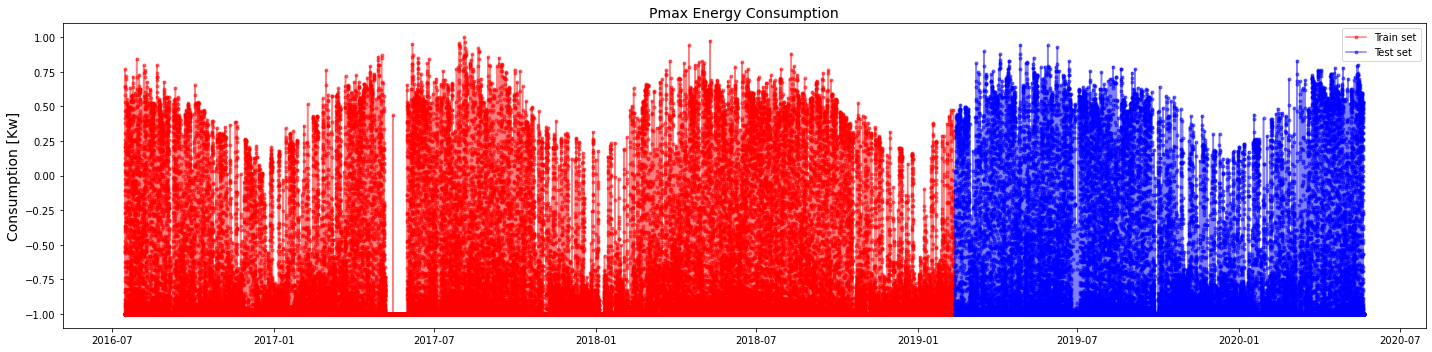

Total Data Size  :134988
Test Data Size  :44546
Train Data Size :90442


In [14]:
    
num_test = len(df_test) 
num_train = len(df_train)
num_total = len(df)


split_index = num_train
X_train_values  = df[:split_index] # get the datetime values of X_train
X_test_values = df[split_index:]

for i in range(len(labels)):
    plt.figure(figsize=(20,5))
    plt.plot(X_train_values.index, np.stack(y_train_scaled,axis=-1)[i], '.-', color='red', label='Train set', alpha=0.5)
    plt.plot(X_test_values.index, np.stack(y_test_scaled,axis=-1)[i], '.-', color='blue', label='Test set', alpha=0.5)
    plt.legend()
    plt.ylabel('Consumption [Kw]', fontsize=14)
    plt.title(labels[i]+' Energy Consumption', fontsize=14)
    plt.tight_layout()
    plt.show()
    

print(f'Total Data Size  :{len(df)}\n'+
f'Test Data Size  :{len(df_test)}\n'+
f'Train Data Size :{len(df_train)}')

#### 1.6 Batch Creation

In [15]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
   
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - 2*sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


X Batch Shape :  (20, 12, 5)
Y Batch Shape :  (20, 12, 5)


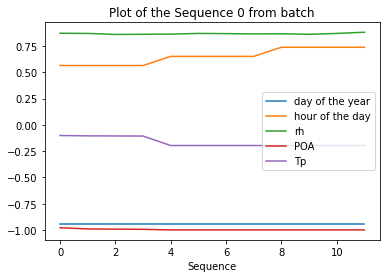

In [16]:
batch_size = 20

generator     = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_test,  x_test_scaled,  y_test_scaled)

x_batch, y_batch = next(generator)

print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')

seq = x_batch[0, :, :]
plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the Sequence 0 from batch')
plt.show()

## 2. LSTM Model

In [17]:
from tensorflow.keras.utils import Progbar


num_neurons = 350  # was 575
learning_rate = 0.00075
num_layers = 2
num_iter = 1000
keep_prob = 0.2

next(testgenerator)


graph = tf.Graph()

hist_mse = np.zeros(num_iter)
with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name='x')
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 
    
    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
    
with graph.as_default():
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])


    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    # from another program 
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels) 
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels],name="op_to_restore")          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        #writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
        
        #saver = tf.train.import_meta_graph('Model'+str(3)+'/my_test_model-1000.meta')
        #saver.restore(sess,tf.train.latest_checkpoint('./Model'+str(3)+'/'))
        best = 50.0
        patience = 0
        limit = 100
        count = 0
        
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch})   
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            hist_mse[count] = mse
            count += 1
            #if mse < best:
            #    saver.save(sess, 'my_test_model',global_step=1000)
            #    best = mse
            #    patience = 0
            #    print(count)
            #    #print('\n Best = ',best)
            #    #print('\n patience = ',patience)
            #else:
            #    patience += 1
            #    #print('\n patience = ',patience)
            #    if patience > limit:
            #        print('\n Early stopping')
            #        break
           # writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
            
            
        #saver.save(sess, 'Model'+str(sequence_length)+'/my_test_model',global_step=1000)
        saver.save(sess, 'my_test_model',global_step=1000)
        
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})

        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})  


plt.plot(range(count-10),hist_mse[10:count]) 

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 249/1000 [======>.......................] - ETA: 1:14 - MSE: 0.0289

KeyboardInterrupt: 

In [ ]:
plt.plot(range(count-20),hist_mse[20:count])

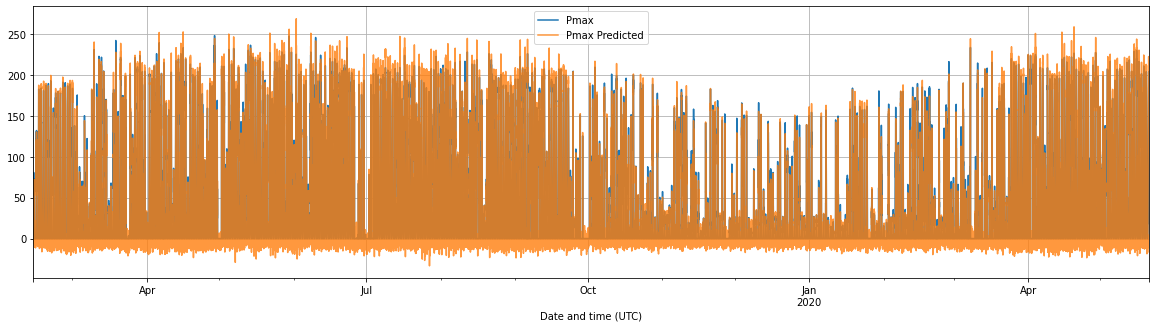

In [63]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=df_test.iloc[0:ind].index, columns=labels)

for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 5))
    df[labels[i]].iloc[num_train:].plot()
    DF[labels[i]].plot( label=labels[i]+' Predicted',alpha=0.8)
    plt.legend()
    plt.grid()
    plt.show()


In [64]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.002
RMSE : 0.049
